In [1]:
import numpy as np
import pandas as pd
import random
import math

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Загрузка данных

##### Описание датасета:

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [4]:
train_df = pd.read_csv('train.csv')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
test_df = pd.read_csv('test.csv')
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [6]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])


Строк в трейне: 10000
Строк в тесте: 5000


In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

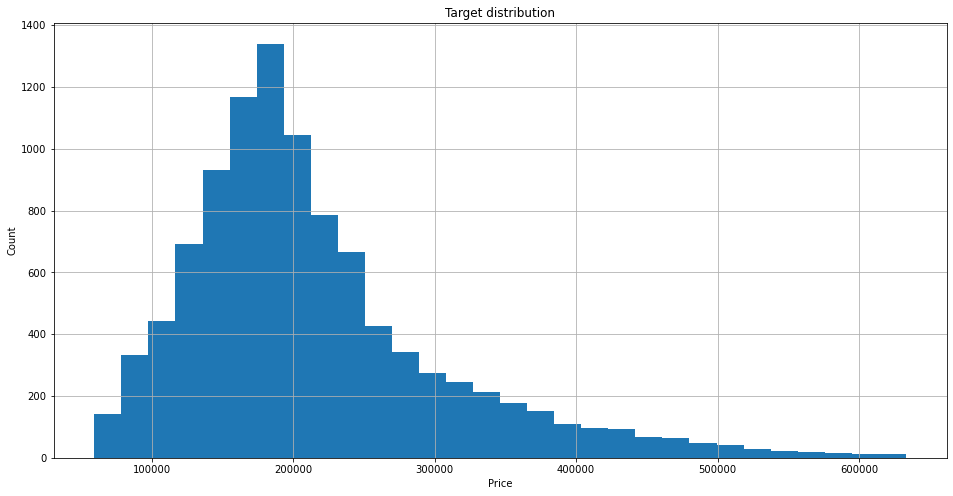

In [9]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [10]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [11]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [12]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
117      1
174      1
205      1
207      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [13]:
train_df['Ecology_2'].value_counts()


B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [15]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### Обработка выбросов

###### Общая площадь

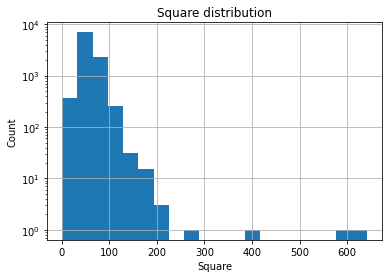

In [16]:
train_df['Square'].hist(bins=20)
plt.yscale("log")
plt.ylabel('Count')
plt.xlabel('Square')

plt.title('Square distribution')
plt.show()

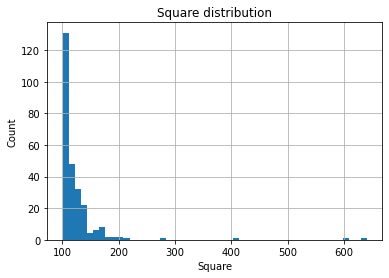

In [17]:
train_df.loc[(train_df['Square'] > 100), 'Square'].hist(bins=50)
#plt.yscale("log")
plt.ylabel('Count')
plt.xlabel('Square')

plt.title('Square distribution')
plt.show()

In [18]:
train_df.loc[(train_df['Square'] > 200), 'Square'].value_counts()

641.065193    1
275.645284    1
212.932361    1
200.334539    1
604.705972    1
409.425181    1
Name: Square, dtype: int64

In [19]:
 train_df.loc[(train_df['Square'] < 15), 'Square'].value_counts()

13.784865    1
1.136859     1
2.596351     1
4.380726     1
2.954309     1
4.390331     1
5.129222     1
1.988943     1
4.633498     1
2.377248     1
4.502784     1
4.823679     1
5.497061     1
Name: Square, dtype: int64

In [20]:
train_df.loc[(train_df['Square'] > 200) | (train_df['Square'] < 15) ].sort_values('Square')[['Square', 'LifeSquare', 'Rooms', 'Price']]

,Square,LifeSquare,Rooms,Price
7470,1.136859,4.525736,1.0,181434.825589
4496,1.988943,2.642219,1.0,458378.777006
9869,2.377248,0.873147,0.0,126596.941798
8572,2.596351,4.604943,1.0,137597.601458
161,2.954309,5.257278,1.0,438005.182323
8805,4.380726,40.805837,1.0,97560.720383
328,4.390331,5.610772,3.0,161379.067034
4800,4.502784,4.618547,1.0,483283.488083
5009,4.633498,1.969969,1.0,107604.269441
9067,4.823679,79.767964,3.0,237716.681261


In [21]:
# В итоге в обучающем датасете обнаружено всего 15 записей, в которых значение общей площади квартиры
# выглядит полностью неадекватным (три записи с площадью более 400 м2 и 12 с площадью менее 6 м2). 
# Представляется логичным эти записи просто удалить. 

train_df = train_df.loc[(train_df['Square'] > 13) & (train_df['Square'] < 300)]
train_df.shape

(9985, 20)

###### Кухня

In [22]:
train_df['KitchenSquare'].value_counts()

1.0       2449
8.0       1306
5.0       1169
10.0      1073
6.0       1038
9.0        843
0.0        695
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [23]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [24]:
# Квантиль .975 выглядит правдоподобной верхней границей для определения выбросов.
# Адекватной нижней границей представляется площадь 4 м2, поскольку даже в хрущевках кухни не меньше.

In [25]:
train_df['KitchenSquare'].median()

6.0

In [26]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

train_df['KitchenSquare'].value_counts()

4.0     3209
8.0     1306
6.0     1227
5.0     1169
10.0    1073
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

###### Жилая площадь

In [27]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,4.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,4.0
9,79.867477,75.085125,4.0


In [28]:
condition = ((train_df['LifeSquare'] > 0) & (train_df['LifeSquare'] < ((train_df['Square'] - train_df['KitchenSquare'])/3)))
#train_df.loc[condition, 'LifeSquare'].value_counts()
train_df.loc[condition][['Square', 'KitchenSquare', 'LifeSquare']]

,Square,KitchenSquare,LifeSquare
26,83.262530,4.0,4.769174
119,63.591740,10.0,0.795539
212,38.936986,4.0,3.064320
227,46.722042,4.0,1.944446
244,101.554252,9.0,22.630373
...,...,...,...
9462,48.232741,4.0,3.288779
9746,43.956044,6.0,10.523868
9912,52.787090,4.0,5.600609
9938,94.888593,4.0,2.637095


In [29]:
# Выберем подмножество записей с "адекватным" соотношением площадей, и вычислим по нему средний коэффициент 
# соотношения жилой и общей площади. 

adequate_square_condition = ((train_df['LifeSquare'] <= (train_df['Square'] - train_df['KitchenSquare'])) & \
                             (train_df['LifeSquare'] >= ((train_df['Square'] - train_df['KitchenSquare'])/2)))
print(train_df.loc[adequate_square_condition].shape)
adequate_squares = train_df.loc[adequate_square_condition]
life_square_ratio = (adequate_squares['LifeSquare'] / adequate_squares['Square']).median()
print(life_square_ratio)

(6431, 20)
0.6049392768755943


In [30]:
bad_square_condition = ((train_df['LifeSquare'].isna()) | \
                        (train_df['LifeSquare'] > (train_df['Square'] - train_df['KitchenSquare'])) | \
                        (train_df['LifeSquare'] < ((train_df['Square'] - train_df['KitchenSquare'])/3)))

print(train_df.loc[bad_square_condition].shape)

train_df.loc[bad_square_condition, 'LifeSquare'] = train_df.loc[bad_square_condition, 'Square'] * life_square_ratio


(3452, 20)


In [31]:
train_df['LifeSquare'].describe()

count    9985.000000
mean       34.154498
std        12.666550
min         8.339006
25%        24.133512
50%        32.140939
75%        41.461090
max       233.949309
Name: LifeSquare, dtype: float64

In [32]:
bad_square_condition = ((train_df['LifeSquare'].isna()) | \
                        (train_df['LifeSquare'] > (train_df['Square'] - train_df['KitchenSquare'])) | \
                        (train_df['LifeSquare'] < ((train_df['Square'] - train_df['KitchenSquare'])/3)))

print(train_df.loc[bad_square_condition].shape)

(3, 20)


In [33]:
adequate_square_condition = ((train_df['LifeSquare'] <= (train_df['Square'] - train_df['KitchenSquare'])) & \
                             (train_df['LifeSquare'] >= ((train_df['Square'] - train_df['KitchenSquare'])/2)))
print(train_df.loc[adequate_square_condition].shape)

(9880, 20)


In [34]:
# В итоге этот способ коррекции LifeSquare показал плохое влияние на модель.
# В итоговом классе пришлось вернуться к способу, предложенному на консультации.

###### Количество комнат

In [35]:
train_df['Rooms'].value_counts()

2.0     3877
1.0     3696
3.0     2233
4.0      150
5.0       18
0.0        7
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [36]:
rooms_condition = ((train_df['Rooms'] > 0) & (train_df['Rooms'] <= 5))
good_room_square = train_df.loc[rooms_condition, 'LifeSquare'] / train_df.loc[rooms_condition, 'Rooms'] 
room_square = train_df.loc[(train_df['Rooms'] > 0), 'LifeSquare'] / train_df.loc[(train_df['Rooms'] > 0), 'Rooms'] 
    
good_room_square = pd.DataFrame(good_room_square, columns = ["room_square"])

good_room_square.quantile(0.9989), good_room_square.quantile(0.0011)

(room_square    82.729028
 Name: 0.9989, dtype: float64,
 room_square    8.798082
 Name: 0.0011, dtype: float64)

In [37]:
q_min = good_room_square.quantile(0.0011)['room_square']

good_room_square.loc[(good_room_square['room_square'] < q_min)]

,room_square
768,4.553157
922,7.035912
2763,6.599914
2799,5.081888
3686,3.336692
5520,7.782936
6489,7.984407
6947,6.613039
7975,4.828151
8501,5.267261


In [38]:
q_max = good_room_square.quantile(0.9989)['room_square']

good_room_square.loc[(good_room_square['room_square'] > q_max)]

,room_square
312,84.613939
761,102.187199
1109,83.296167
2388,87.387096
2462,84.122714
5259,103.637322
5283,105.652355
5764,125.486563
6030,98.778698
6909,89.639313


In [39]:
good_room_square.mean(), good_room_square.median()

(room_square    19.373059
 dtype: float64,
 room_square    18.185051
 dtype: float64)

In [40]:
# Еще раз запоминаем квантили и медиану
q_min = good_room_square.quantile(0.0011)['room_square']
q_max = good_room_square.quantile(0.9989)['room_square']
room_square_median = good_room_square.median()['room_square']

# Временно расширяем датасет признаком "средняя площадь одной комнаты в квартире"
train_df['RoomSquare'] = train_df['LifeSquare'] / train_df['Rooms']

# Формулируем условие "неадекватного" количества комнат
# Неадекватными значениями кол-ва комнат считаем кол-во 0 и более 6,
# а также то, где посчитанная средняя площадь одной комнаты выходит за квантили
bad_rooms_condition = ((train_df['Rooms'].isna()) | (train_df['Rooms'] <= 0) | (train_df['Rooms'] > 6) | \
                        ((train_df['RoomSquare'] < q_min) | \
                        (train_df['RoomSquare'] > q_max)))

# Добавляем признак "Выброс кол-ва комнат" по условию выше
train_df['Rooms_outlier'] = 0
train_df.loc[bad_rooms_condition, 'Rooms_outlier'] = 1

# Корректируем кол-во комнат по условию выше
train_df.loc[(bad_rooms_condition & (train_df['LifeSquare'] > room_square_median)), "Rooms"] = round(train_df.loc[bad_rooms_condition, "LifeSquare"] / room_square_median)
train_df.loc[(bad_rooms_condition & (train_df['LifeSquare'] <= room_square_median)), "Rooms"] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,RoomSquare,Rooms_outlier
0,11809,27,3.0,115.027311,69.584538,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,23.194846,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,23.169223,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,15.890657,0
3,2352,1,1.0,40.409907,24.445540,4.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,24.445540,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,19.281258,0


In [41]:
train_df['Rooms'].value_counts()

2.0    3879
1.0    3699
3.0    2229
4.0     149
5.0      24
6.0       3
7.0       2
Name: Rooms, dtype: int64

In [42]:
train_df['Rooms'].value_counts()

2.0    3879
1.0    3699
3.0    2229
4.0     149
5.0      24
6.0       3
7.0       2
Name: Rooms, dtype: int64

###### Этаж и этажность

In [43]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [44]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [45]:
train_df['Floor'].value_counts()

4     948
5     876
3     869
6     801
7     759
8     642
9     604
2     588
10    552
11    457
12    438
13    398
14    362
16    290
15    287
17    255
1     233
18    184
19    121
20     67
21     58
22     54
24     52
25     34
23     25
26     18
27      5
28      2
32      2
42      1
33      1
37      1
31      1
Name: Floor, dtype: int64

In [46]:
# Этажность жилых комплексов бывает самая разная, так что этажи квартир трогать не будем.
# (только добавим правку на случай пропусков/нулей в будущем тестовом датасете)
train_df.loc[(train_df['Floor'].isna() | (train_df['Floor'] == 0)), "Floor"] = 1

In [47]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1817

In [48]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [49]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [50]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers


Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1603)

In [51]:
# Чисто интуитивно, этаж квартиры представляется признаком, сбор информации по которому должен быть более надежен.
# Поэтому будем отталкиваться от него, и если этаж превышает этажность - увеличим этажность.

train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor'] = \
    train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor']

In [52]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

###### Год постройки

In [53]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
1976        2020
5412        2020
5641        2020
          ...   
7610        1916
6250        1914
2795        1912
2066        1912
6794        1910
Name: HouseYear, Length: 9985, dtype: int64

In [54]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [55]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4789
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
RoomSquare               0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [56]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [57]:
# Переводим всё в форму класса

class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.life_square_ratio = None
        self.room_min = None
        self.room_max = None
        self.room_square_median = None
        
    def trim_train_dataset(self, X):
        """Удаление записей с неадекватной общей площадью (только для train)"""       
        X = X.loc[(X['Square'] > 13) & (X['Square'] < 300)]
        return X        

    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        X = X.copy()
        
        """Кухня"""       
        condition = (X['KitchenSquare'].isna()) \
             | (X['KitchenSquare'] > X['KitchenSquare'].quantile(.975))     
        X.loc[condition, 'KitchenSquare'] = X['KitchenSquare'].median()
        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = 4

        """Жилплощадь"""       
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        """Комнаты"""       
        rooms_condition = ((X['Rooms'] > 0) & (X['Rooms'] <= 5))
        good_room_square = X.loc[rooms_condition, 'LifeSquare'] / X.loc[rooms_condition, 'Rooms'] 

        # Еще раз запоминаем квантили и медиану
        self.room_min = good_room_square.quantile(0.0011)
        self.room_max = good_room_square.quantile(0.9989)
        self.room_square_median = good_room_square.median()
        print("Квантили комнат:", self.room_min, self.room_max, self.room_square_median)
        
        
    def transform(self, X):
        """Трансформация данных"""

        # Кухня
        condition = (X['KitchenSquare'].isna()) \
             | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        # Добавляем признак "Выброс по кухне" 
        X['Kitchen_outlier'] = 0
        X.loc[(condition & (X['KitchenSquare'] < 4)), 'Kitchen_outlier'] = 1

        # Коррекция площади кухни 
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = 4

        # Жилплощадь     
        X['LifeSquare_outlier'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

        # Комнаты

        # Временно расширяем датасет признаком "средняя площадь одной комнаты в квартире"
        X['RoomSquare'] = X['LifeSquare'] / X['Rooms']

        # Формулируем условие "неадекватного" количества комнат
        # Неадекватными значениями кол-ва комнат считаем кол-во 0 и более 6,
        # а также то, где посчитанная средняя площадь одной комнаты выходит за квантили
        bad_rooms_condition = ((X['Rooms'].isna()) | (X['Rooms'] <= 0) | (X['Rooms'] > 6) | \
                                ((X['RoomSquare'] < self.room_min) | \
                                (X['RoomSquare'] > self.room_max)))

        # Добавляем признак "Выброс кол-ва комнат"
        X['Rooms_outlier'] = 0
        X.loc[bad_rooms_condition, 'Rooms_outlier'] = 1

        # Коррекция кол-ва комнат
        X.loc[(bad_rooms_condition & (X['LifeSquare'] > self.room_square_median)), "Rooms"] = round(X.loc[bad_rooms_condition, "LifeSquare"] / self.room_square_median)
        X.loc[(bad_rooms_condition & (X['LifeSquare'] <= self.room_square_median)), "Rooms"] = 1
        
        # Убираем временный признак
        X.drop('RoomSquare', axis=1, inplace=True)

        # Этажи

        # Добавляем признак "Выброс этажности"
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'].isna() | (X['HouseFloor'] == 0)), 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

        # Коррекция этажа
        X.loc[(X['Floor'].isna() | (X['Floor'] == 0)), "Floor"] = 1

        # Коррекция этажности
        X.loc[(X['HouseFloor'].isna() | (X['HouseFloor'] == 0)), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'] = \
            X.loc[X['Floor'] > X['HouseFloor'], 'Floor']      
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)        
        
        X.fillna(self.medians, inplace=True)
        
        return X

#### Построение новых признаков

In [58]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [59]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,847
1,1,650
2,23,565
3,6,510
4,9,293


In [60]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,RoomSquare,Rooms_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,69.584538,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,23.194846,0,0,847
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,23.169223,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,15.890657,0,0,650
3,2352,1,1.0,40.409907,24.445540,4.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,24.445540,0,0,650
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,19.281258,0,0,89


In [61]:
district_size.shape

(205, 2)

In [62]:
(train_df['DistrictSize'] > 100).value_counts()

True     5058
False    4927
Name: DistrictSize, dtype: int64

In [63]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [64]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142486.170594
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,0,5.0,289034.391871
4,1,1.0,146341.760143


In [65]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,RoomSquare,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,69.584538,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,23.194846,0,0,847,1,214110.643802
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,23.169223,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,15.890657,0,0,650,1,244305.358328
3,2352,1,1.0,40.409907,24.445540,4.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,24.445540,0,0,650,1,146341.760143
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,19.281258,0,0,89,0,201584.441255


In [66]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [67]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9980    0
9981    3
9982    0
9983    0
9984    2
Name: Floor, Length: 9985, dtype: int64

In [68]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)


0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9980      (0, 3]
9981     (9, 15]
9982      (0, 3]
9983      (0, 3]
9984      (5, 9]
Name: Floor, Length: 9985, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [69]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,RoomSquare,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,69.584538,10.0,4,10.0,2014,0.075424,...,1,305018.871089,23.194846,0,0,847,1,214110.643802,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,23.169223,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,15.890657,0,0,650,1,244305.358328,4,1
3,2352,1,1.0,40.409907,24.445540,4.0,10,22.0,1977,0.007122,...,1,168106.007630,24.445540,0,0,650,1,146341.760143,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,19.281258,0,0,89,0,201584.441255,3,5


In [70]:
# Переводим всё в форму класса

class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.district_priv = None
        self.district_priv_median = None
        self.district_floors = None
        self.district_floors_median = None    
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        # Качество жизни в районе
        # Поскольку признаки Shops_1 и Social_1/2/3 положительно коррелированы друг с другом,
        # можно попробовать создать новую фичу, отражающую общее кач-во жизни в районе
        df['District_sum'] = df['Shops_1'] + df['Social_1'] + df['Social_2'] + df['Social_3']
        self.district_priv = df.groupby(['DistrictId'], as_index=False).agg({'District_sum':'median'}).\
                                            rename(columns={'District_sum':'District_life_quality'})
        self.district_priv_median = self.district_priv['District_life_quality'].median()
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
#         More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
#         Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        # DistrictWellness
        X = X.merge(self.district_priv, on=['DistrictId'], how='left')
        X.fillna(self.district_priv_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

#### Отбор признаков

In [71]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'RoomSquare',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat']

In [72]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
# feature_names = ['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                  'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
#                  'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Kitchen_outlier', 'LifeSquare_outlier', 'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
                     'DistrictSize', 'new_district', 'IsDistrictLarge', 'District_life_quality'
                     #'MedPriceByDistrict', 
                     #'MedPriceByFloorYear'
                    ]

target_name = 'Price'

#### Разбиение на train и test

In [73]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

preprocessor = DataPreprocessing()
features_gen = FeatureGenetator()

train_df = preprocessor.trim_train_dataset(train_df)

X = train_df.drop(columns=target_name)
y = train_df[target_name]


In [74]:
X.shape

(9985, 19)

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)


In [76]:
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

Квантили комнат: 0.6116779462390405 111.91252375303614 19.779323701533617


((6689, 23), (3296, 23), (5000, 23))

In [77]:
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6689, 31), (3296, 31), (5000, 31))

In [78]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [79]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

#### Построение модели

In [80]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse',
                                 n_estimators= 800,
                                 max_depth= 16,
                                 max_features = 7,
                                 min_samples_leaf = 1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, max_features=7, n_estimators=800,
                      random_state=21)

Train R2:	0.949
Test R2:	0.75


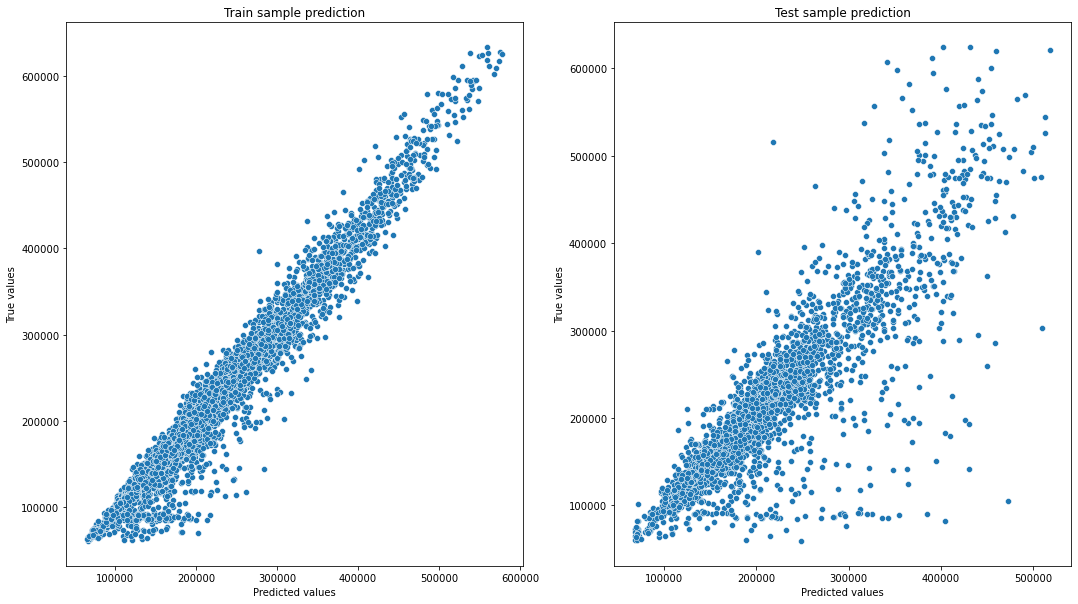

In [81]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [82]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.279521
0,Rooms,0.112561
21,DistrictSize,0.105354
2,LifeSquare,0.097371
12,Social_3,0.047070
23,IsDistrictLarge,0.046631
11,Social_2,0.043856
10,Social_1,0.042530
6,HouseYear,0.038236
24,District_life_quality,0.035626


Train R2:	0.865
Test R2:	0.755


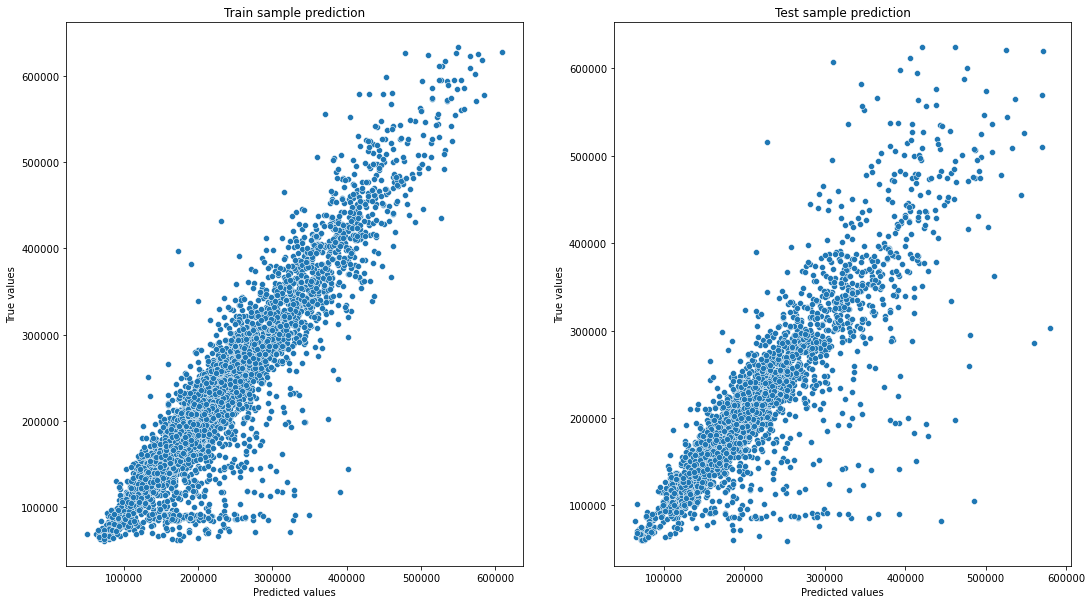

In [83]:
# gb_model = GradientBoostingRegressor(criterion='mse',
#                                      max_depth=7,
#                                      min_samples_leaf=10,
#                                      random_state=42,  
#                                      n_estimators=100)
gb_model = GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=10,
                                     max_depth=5,
                                     max_features=6,
                                     n_estimators=200,
                                     random_state=21  
                                    )
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [84]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.348013
21,DistrictSize,0.094334
0,Rooms,0.090793
10,Social_1,0.071073
12,Social_3,0.066641
2,LifeSquare,0.061399
23,IsDistrictLarge,0.044204
24,District_life_quality,0.040707
7,Ecology_1,0.030430
11,Social_2,0.028313


Train R2:	0.904
Test R2:	0.754


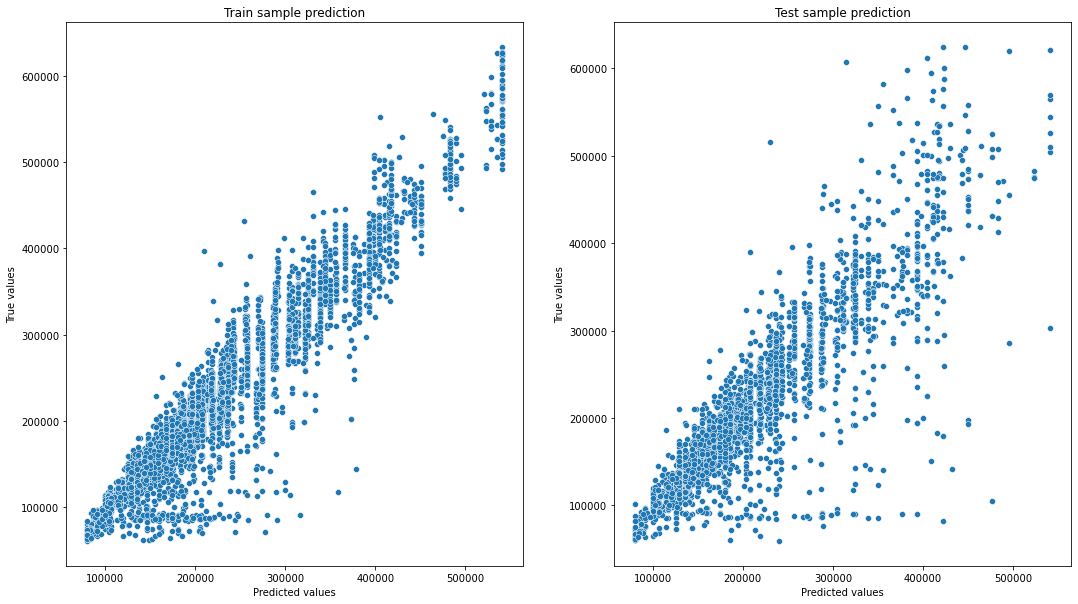

In [85]:
# Итоговое предсказание будем делать через StackingRegressor

rf_stack_model = RandomForestRegressor(random_state=21, criterion='mse',
                                 n_estimators= 800,
                                 max_depth= 16,
                                 max_features = 7,
                                 min_samples_leaf = 1)
gb_stack_model = GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=10,
                                     max_depth=5,
                                     max_features=6,
                                     n_estimators=200,
                                     random_state=21  
                                    )
gb = GradientBoostingRegressor(max_depth=1,
                               random_state=21,
                               min_samples_leaf=15,
                               n_estimators=200)

stack = StackingRegressor([('rf', rf_stack_model), ('gb', gb_stack_model)], final_estimator=gb)
stack.fit(X_train, y_train)

y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)


#### Итоговый прогноз

In [86]:
test_df.shape

(5000, 25)

In [87]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Kitchen_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,DistrictSize,new_district,IsDistrictLarge,District_life_quality
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,0,0,0,0,0,74.0,0,0,4754.0
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,149.0,0,1,632.0
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,0,1,0,0,0,571.0,0,1,919.0
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,1,0,0,0,0,0,372.0,0,1,477.0
4,1.0,53.837056,46.837056,4.0,8,17.0,1977,0.309479,1,1,...,1,0,1,0,0,0,84.0,0,0,1448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6,6.0,1962,0.069660,1,1,...,1,0,0,0,1,0,57.0,0,0,6156.0
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,1,0,0,0,0,0,22.0,0,0,2811.0
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,1,0,0,0,0,0,67.0,0,0,6608.0
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,1,0,0,0,0,0,30.0,0,0,8025.0


In [88]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [89]:
predictions = stack.predict(test_df)
predictions

array([159357.17132665, 116578.82934205, 145277.90926551, ...,
       145797.64837444, 194056.12102593, 240253.66991993])

In [90]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,159357.171327
1,5925,116578.829342
2,960,145277.909266
3,3848,123394.557049
4,746,196789.908347


In [91]:
submit.to_csv('stack_submit06.csv', index=False)